Making euv scaling for all of the MM stars.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [2]:
path = '/media/david/5tb_storage1/muscles/'
sv1 = path + 'euv_txt_files/'
sv2 = path + 'euv_hlsp/'

In [6]:
params = Table.read(path + 'mega_muscles_stellar_parameters.csv')

In [7]:
import prepare_euv
import prepare_model

In [26]:
def euv_estimator(euv_inputs, save_path, star, save=True):
    
    lya, distance = euv_inputs['lya'], euv_inputs['distance']
        
    distance_conversion = ((1*u.au.to(u.m))/(distance*u.pc.to(u.m)))**2

    lya_1au = lya / distance_conversion

    w1 = np.array([100,200,300,400,500,600,700,800,912], dtype=float) #A
    w2 = np.array([200,300,400,500,600,700,800,912,1170], dtype=float)
    bandwidth = w2-w1

    a = np.array([-0.491,-0.548,-0.602,-2.294,-2.098,-1.920,-1.894,-1.811,-1.004], dtype=float)
    b = np.array([ 0.,    0.,    0.,    0.258, 0.572, 0.240, 0.518, 0.764, 0.065], dtype=float)

    #log(f/lya) = a + b *log(lya)
    f = a + b*np.log10(lya_1au)
 #   print(f[0])

   # print('Total EUV=',np.sum(f))
    f = (lya_1au * 10**f)/bandwidth
  #  print(f[0])


    f *= distance_conversion
   # print(f[0])

    #extrapolate onto 1A grid
    wavelength = np.arange((w1[0])+0.5, (w2[-1])+0.5, 1.0)
    f_to_interp = np.hstack((f[0], f, f[-1])) #adding extra values onto the ends so the interpolation doesn't make nans
    w_to_interp = np.hstack((w1[0], np.mean([w1, w2], axis=0), w2[-1]))
    flux = interpolate.interp1d(w_to_interp, f_to_interp, kind='nearest', bounds_error=False)(wavelength)
   # print(flux[0])

    if os.path.exists(save_path) == False:
        os.mkdir(save_path)
    if star != '':
        star = '{}_'.format(star)
    filename = '{}l14euv_lya{}_d{}.txt'.format(star, euv_inputs['lya'], euv_inputs['distance'])
    savedat = Table([wavelength, flux], names=['WAVELENGTH', 'FLUX'])
    ascii.write(savedat, save_path+filename, overwrite=True)
    

In [27]:
for row in params:
    star = row['Target']
    if star != 'Trappist-1':
        lya = row['lya_flux']
        distance= row['distance']
        if lya > 0:
            euv_estimator(dict(distance=distance, lya=lya), sv1, star = star.replace(' ',''), )

                        
            

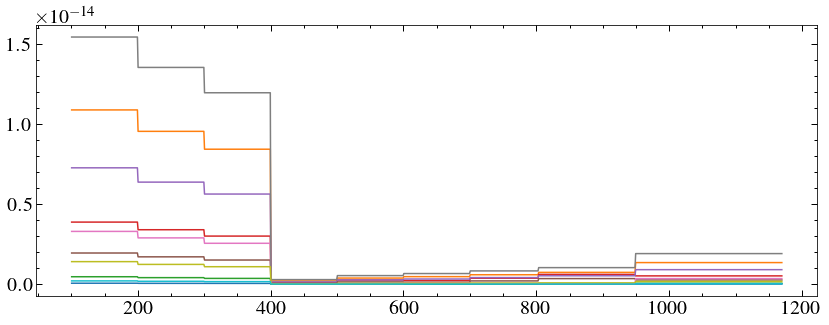

In [29]:
txt_files = glob.glob('{}*.txt'.format(sv1))
for sp in txt_files:
    data = Table.read(sp, format = 'ascii')
    w, f = data['WAVELENGTH'], data['FLUX']
    plt.plot(w,f)